# A Gentle Introduction to Transfer Learning

In [86]:
import sys
import os
import numpy as np
from collections import Counter
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import lr_scheduler
from torch.autograd import Variable
from torchvision import models
from utils import get_gpu_name, get_number_processors, plot_pytorch_data_stream, train_model

print("OS: ", sys.platform)
print("Python: ", sys.version)
print("PyTorch: ", torch.__version__)
print("Numpy: ", np.__version__)
print("Number of CPU processors: ", get_number_processors())
print("GPU: ", get_gpu_name())

%matplotlib inline
%load_ext autoreload
%autoreload 2

OS:  linux
Python:  3.5.2 |Anaconda custom (64-bit)| (default, Jul  2 2016, 17:53:06) 
[GCC 4.4.7 20120313 (Red Hat 4.4.7-1)]
PyTorch:  0.2.0_3
Numpy:  1.13.3
Number of CPU processors:  24
GPU:  ['Tesla M60', 'Tesla M60', 'Tesla M60', 'Tesla M60']
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [76]:
torch.backends.cudnn.benchmark=True # enables cudnn's auto-tuner

In [77]:
BATCH_SIZE = 64
SETS = ['train', 'val']

## Model and utilities

In [90]:
def finetune(dataloders):
    num_class = len(dataloaders['train'].dataset.class_to_idx)
    model_ft = models.resnet18(pretrained=True)
    num_ftrs = model_ft.fc.in_features
    model_ft.fc = nn.Linear(num_ftrs, num_class)
    model_ft = model_ft.cuda()
    #loss
    criterion = nn.CrossEntropyLoss()

    # Observe that all parameters are being optimized
    optimizer = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

    # Decay LR by a factor of 0.1 every 7 epochs
    exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
    model_ft = train_model(dataloders, model_ft, criterion, optimizer, exp_lr_scheduler, num_epochs=25)
    return model_ft

In [79]:
def freeze_and_train():
    pass

## Datasets
We are going to use the dataset [hymenoptera](https://download.pytorch.org/tutorial/hymenoptera_data.zip)

In [80]:
DATA_ROOT = 'data'
HYMENOPTERA_ROOT = os.path.join(DATA_ROOT, 'hymenoptera_data')

In [81]:
data_hymenoptera = create_dataset(HYMENOPTERA_ROOT)

There are 2 clases in the dataset: {'bees': 1, 'ants': 0}
Sets sizes:  {'train': 244, 'val': 153}
Number of items in set train: {0: 123, 1: 121}
Number of items in set val: {0: 70, 1: 83}


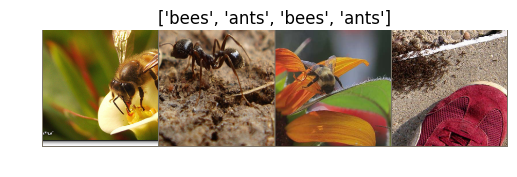

In [82]:
plot_pytorch_data_stream(data_hymenoptera['train'], max_images=4)

In [103]:
model = finetune(data_hymenoptera)

Epoch 0/24
----------
train Loss: 0.6273 Acc: 19.3750
val Loss: 0.5151 Acc: 22.8000

Epoch 1/24
----------
train Loss: 0.4534 Acc: 26.2500
val Loss: 0.3112 Acc: 27.4000

Epoch 2/24
----------
train Loss: 0.2908 Acc: 27.8750
val Loss: 0.2256 Acc: 28.6000

Epoch 3/24
----------
train Loss: 0.2122 Acc: 28.5000
val Loss: 0.1968 Acc: 28.6000

Epoch 4/24
----------
train Loss: 0.1958 Acc: 28.5000
val Loss: 0.1794 Acc: 28.8000

Epoch 5/24
----------
train Loss: 0.1491 Acc: 29.1250
val Loss: 0.1653 Acc: 28.8000

Epoch 6/24
----------
train Loss: 0.1729 Acc: 28.0000
val Loss: 0.1709 Acc: 29.0000

Epoch 7/24
----------
train Loss: 0.1154 Acc: 29.6250
val Loss: 0.1666 Acc: 29.0000

Epoch 8/24
----------
train Loss: 0.1446 Acc: 28.8750
val Loss: 0.1614 Acc: 28.6000

Epoch 9/24
----------
train Loss: 0.1350 Acc: 28.8750
val Loss: 0.1610 Acc: 28.6000

Epoch 10/24
----------
train Loss: 0.1974 Acc: 28.2500
val Loss: 0.1571 Acc: 28.6000

Epoch 11/24
----------
train Loss: 0.1288 Acc: 29.3750
val Loss: